In [1]:
library(readxl) ## Leer excel
library(tidyverse) ## Manipular base de datos
library(igraph) ## Grafos
library(expm) 
library(writexl)
library(ggraph)
library(tidygraph)  # para manipular grafos estilo tidy


â”€â”€ Attaching core tidyverse packages â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€ tidyverse 2.0.0 â”€â”€
âœ” dplyr     1.1.4     âœ” readr     2.1.5
âœ” forcats   1.0.0     âœ” stringr   1.5.1
âœ” ggplot2   3.5.2     âœ” tibble    3.3.0
âœ” lubridate 1.9.4     âœ” tidyr     1.3.1
âœ” purrr     1.1.0     
â”€â”€ Conflicts â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€ tidyverse_conflicts() â”€â”€
âœ– dplyr::filter() masks stats::filter()
âœ– dplyr::lag()    masks stats::lag()
â„¹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Adjuntando el paquete: 'igraph'


The following objects are masked from 'package:lubridate':

    %--%, union


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:purrr':

    compose, simplify


The following object

In [14]:
# Lee un archivo Excel ubicado en la ruta especificada
matriz <- read_excel(
    "C:/Users/cfutr/OneDrive/Escritorio/CICS/2025/Tesis/Objetivos de Aprendizaje/Modelo/datos/Raw_Data/Matriz_de_Adyacencia_Pensiones_v5.xlsx", col_names=TRUE)

In [16]:
# Toma el data frame `matriz` (cargado desde un archivo Excel previamente)
# y lo transforma en una matriz de adyacencia numÃ©rica.

matriz_adj<-matriz%>%
  column_to_rownames(var = colnames(.)[1])%>% #Convierte la primera columna (por ejemplo, "Concepto") en los nombres de las filas.                         
  mutate(across(everything(), as.numeric)) %>%  #Aplica `as.numeric()` a todas las columnas del data frame.
  as.matrix() #Convierte el data frame limpio en una matriz

# Reemplaza todos los valores NA (valores perdidos) en la matriz de adyacencia `matriz_adj` por ceros.
matriz_adj[is.na(matriz_adj)] <- 0

# Crea un grafo dirigido (objeto de clase `igraph`) a partir de la matriz de adyacencia `matriz_adj`.
g <- graph_from_adjacency_matrix(matriz_adj, mode = "directed")

In [17]:
# Convertimos a data.frame las aristas
aristas <- as_data_frame(g, what = "edges")

# Generamos un identificador de cada par como "A--B" ordenado alfabÃ©ticamente
aristas$pair_id <- apply(aristas[, c("from", "to")], 1, function(x) paste(sort(x), collapse = "--"))

# Contamos cuÃ¡ntas veces aparece cada par (si es 2, hay doble direcciÃ³n)
dobles <- aristas %>%
  group_by(pair_id) %>%
  filter(n() == 2) %>%
  ungroup()

# Resultado: lista de aristas que forman relaciones bidireccionales
dobles

from to pair_id

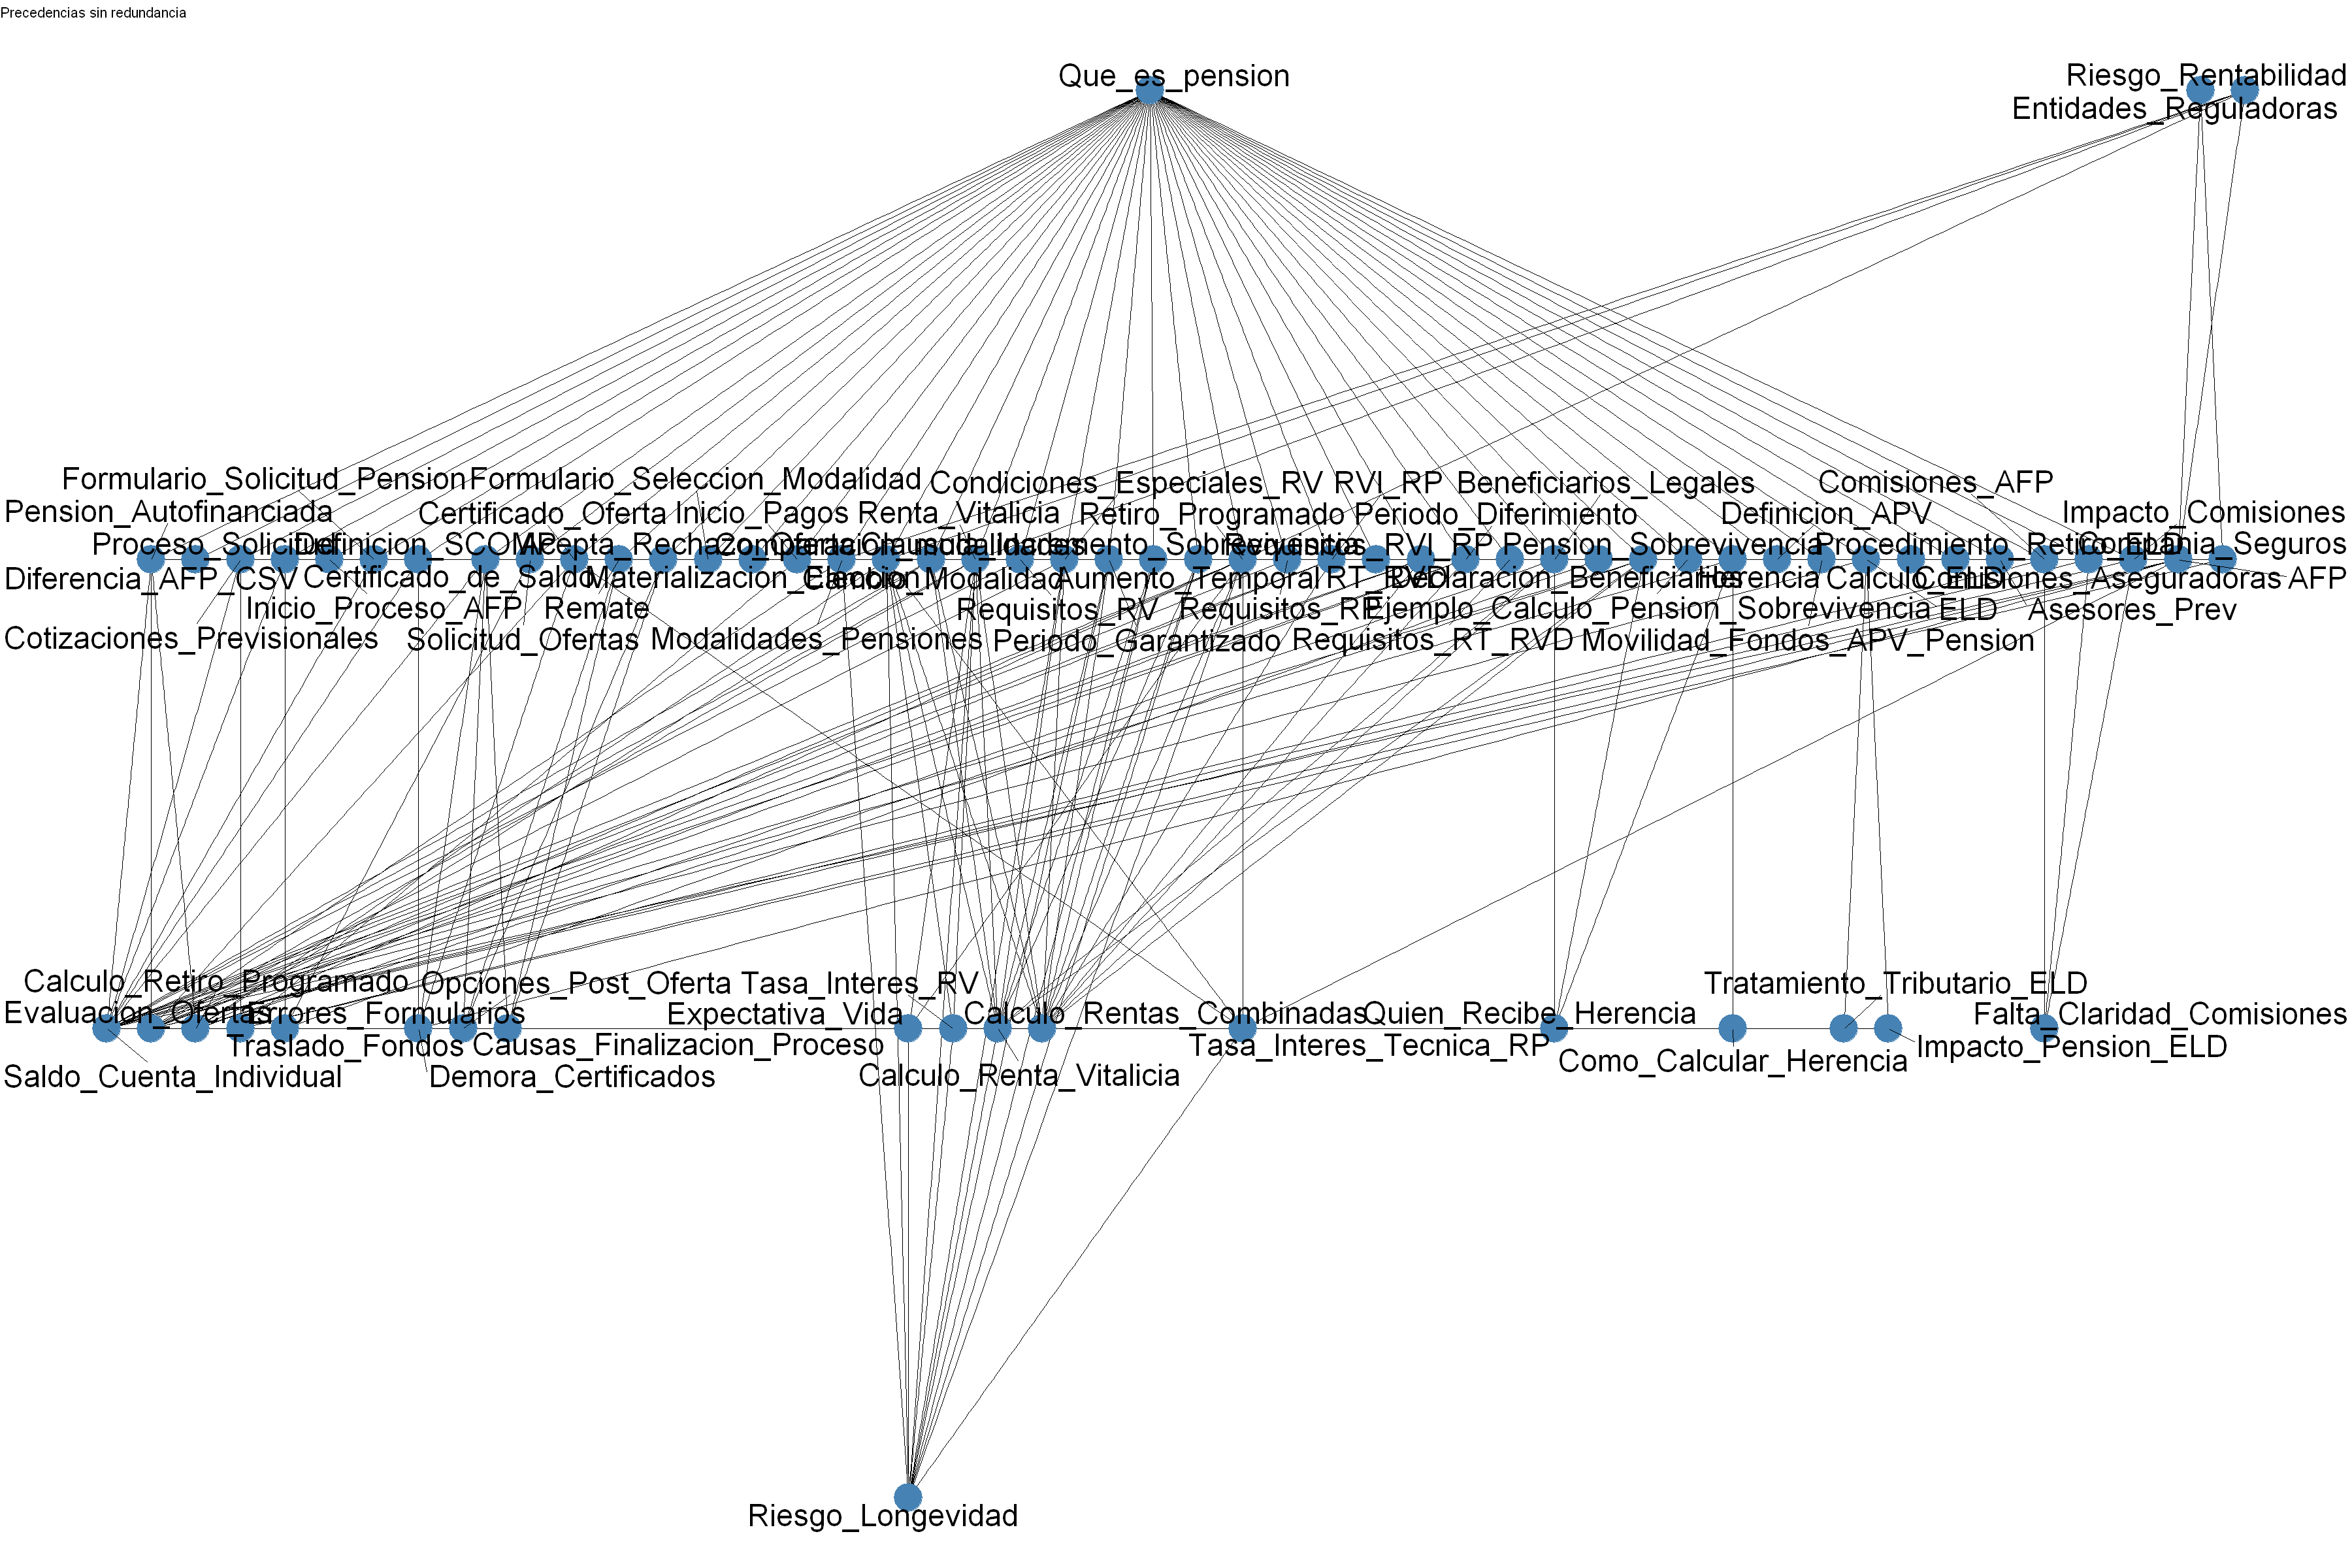

In [18]:
options(repr.plot.width = 30, repr.plot.height = 20)
# Convertir tu grafo igraph a tidygraph
grafo_tidy <- as_tbl_graph(g)

# Visualizar
ggraph(grafo_tidy, layout = "tree") +
  geom_edge_link(arrow = arrow(length = unit(1, 'mm')), end_cap = circle(2.5, 'mm')) +
  geom_node_point(size = 12, color = "steelblue") +
  geom_node_text(aes(label = name), repel = TRUE, size = 10, max.overlaps = Inf) +
  theme_void() +
  ggtitle("Precedencias sin redundancia")

In [20]:
eliminar_aristas_redundantes <- function(g) {
  aristas <- as_data_frame(g, what = "edges")
  redundantes <- c()

  for (i in seq_len(nrow(aristas))) {
    from <- aristas$from[i]
    to   <- aristas$to[i]
    
    # Eliminar temporalmente la arista
    g_temp <- delete_edges(g, E(g, P = c(from, to)))

    # Comprobar si existe otra ruta de from a to
    caminos <- suppressWarnings(all_simple_paths(g_temp, from = from, to = to))
    
    # Solo marcar como redundante si hay otro camino alternativo
    if (length(caminos) > 0) {
      redundantes <- c(redundantes, i)
    }
    cat(sprintf("Revisando %d de %d: %s â†’ %s\n", i, nrow(aristas), from, to))
  flush.console()
  }

  # Eliminar aristas redundantes del grafo original
  g_sin <- delete_edges(g, E(g)[redundantes])
  return(g_sin)
}


In [21]:
g_sin_redundancia <- eliminar_aristas_redundantes(g)


Revisando 1 de 396: Que_es_pension â†’ Pension_Autofinanciada
Revisando 2 de 396: Que_es_pension â†’ Diferencia_AFP_CSV
Revisando 3 de 396: Que_es_pension â†’ Cotizaciones_Previsionales
Revisando 4 de 396: Que_es_pension â†’ Proceso_Solicitud
Revisando 5 de 396: Que_es_pension â†’ Inicio_Proceso_AFP
Revisando 6 de 396: Que_es_pension â†’ Formulario_Solicitud_Pension
Revisando 7 de 396: Que_es_pension â†’ Certificado_de_Saldo
Revisando 8 de 396: Que_es_pension â†’ Definicion_SCOMP
Revisando 9 de 396: Que_es_pension â†’ Solicitud_Ofertas
Revisando 10 de 396: Que_es_pension â†’ Certificado_Oferta
Revisando 11 de 396: Que_es_pension â†’ Remate
Revisando 12 de 396: Que_es_pension â†’ Acepta_Rechazo_Oferta
Revisando 13 de 396: Que_es_pension â†’ Formulario_Seleccion_Modalidad
Revisando 14 de 396: Que_es_pension â†’ Materializacion_Eleccion
Revisando 15 de 396: Que_es_pension â†’ Inicio_Pagos
Revisando 16 de 396: Que_es_pension â†’ Modalidades_Pensiones
Revisando 17 de 396: Que_es_pension â†’

In [22]:
matriz_sin_redundancia <- as_adjacency_matrix(g_sin_redundancia, sparse = FALSE)

In [23]:
# Crea un grafo dirigido a partir de la matriz de adyacencia sin redundancias.

g_sin_redundancia <- graph_from_adjacency_matrix(
  matriz_sin_redundancia,
  mode = "directed",
  diag = FALSE
)

Using "stress" as default layout


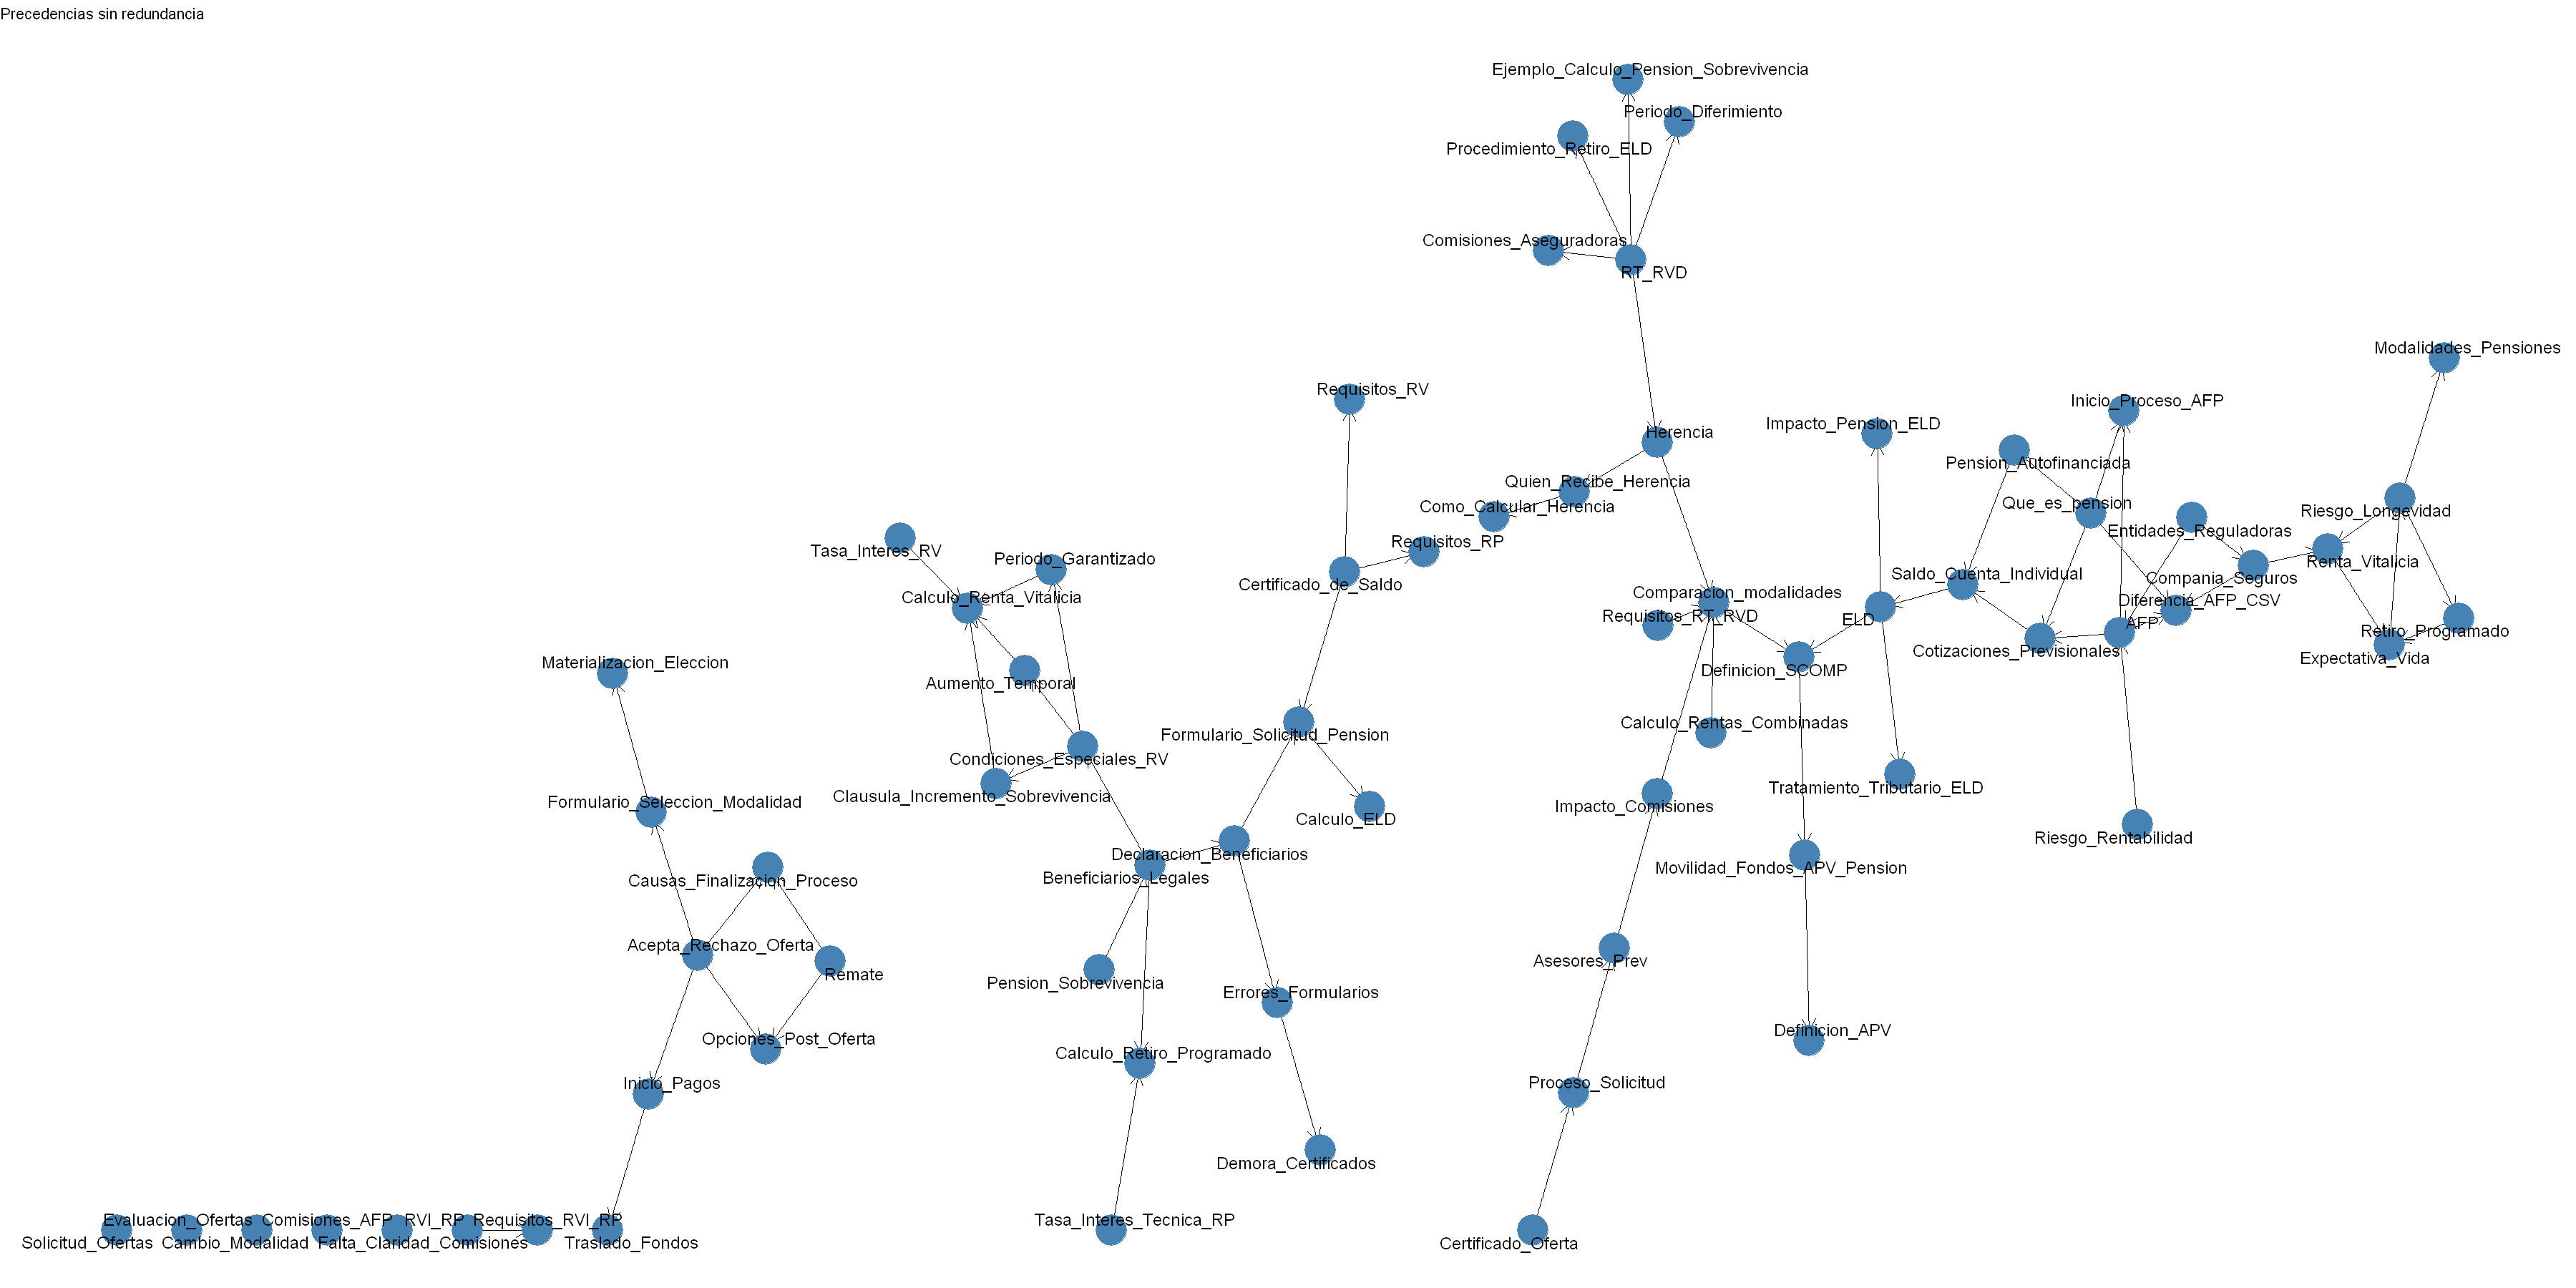

In [24]:
options(repr.plot.width = 30, repr.plot.height = 15)
# Convertir tu grafo igraph a tidygraph
grafo_tidy <- as_tbl_graph(g_sin_redundancia)

# Visualizar
ggraph(grafo_tidy) +
  geom_edge_link(arrow = arrow(length = unit(4, 'mm')), end_cap = circle(3, 'mm')) +
  geom_node_point(size = 12, color = "steelblue") +
  geom_node_text(aes(label = name), repel = TRUE, size = 5, max.overlaps = Inf) +
  theme_void() +
  ggtitle("Precedencias sin redundancia")

In [25]:
# Convertimos a data.frame y agregamos la columna con los nombres de fila
df_matriz <- as.data.frame(matriz_sin_redundancia)
df_matriz <- tibble::rownames_to_column(df_matriz, var = "Concepto")
write_xlsx(df_matriz, path = "matriz_sin_redundancia_v2.xlsx")


In [26]:
ggsave(
  filename = "grafo_precedencias_v2.png",
  width = 30,
  height = 15,
  dpi = 300  # alta resoluciÃ³n
)


In [27]:
# Lista para almacenar los caminos hacia atrÃ¡s
caminos_hacia_atras <- list()

# Iterar sobre cada nodo del grafo
for (v in V(g_sin_redundancia)) {
  nombre_nodo <- V(g_sin_redundancia)$name[v]
  
  # Mostrar nodo que se estÃ¡ procesando
  cat(sprintf("ðŸ”„ Procesando caminos hacia: %s\n", nombre_nodo))
  flush.console()

  # Obtener todos los nodos desde los que se puede llegar a 'v'
  predecesores <- V(g_sin_redundancia)[suppressWarnings(subcomponent(g_sin_redundancia, v, mode = "in"))]
  
  # Obtener todos los caminos simples hacia 'v' desde cada predecesor
  caminos <- list()
  for (p in predecesores$name) {
    if (p != nombre_nodo) {
      caminos_desde_p <- suppressWarnings(all_simple_paths(g_sin_redundancia, from = p, to = nombre_nodo, mode = "out"))
      if (length(caminos_desde_p) > 0) {
        caminos[[p]] <- lapply(caminos_desde_p, function(path) V(g_sin_redundancia)$name[path])
      }
    }
  }

  # Guardar todos los caminos hacia el nodo actual
  caminos_hacia_atras[[nombre_nodo]] <- caminos
}

ðŸ”„ Procesando caminos hacia: Que_es_pension
ðŸ”„ Procesando caminos hacia: Pension_Autofinanciada
ðŸ”„ Procesando caminos hacia: Entidades_Reguladoras
ðŸ”„ Procesando caminos hacia: AFP
ðŸ”„ Procesando caminos hacia: Compania_Seguros
ðŸ”„ Procesando caminos hacia: Diferencia_AFP_CSV
ðŸ”„ Procesando caminos hacia: Cotizaciones_Previsionales
ðŸ”„ Procesando caminos hacia: Saldo_Cuenta_Individual
ðŸ”„ Procesando caminos hacia: Proceso_Solicitud
ðŸ”„ Procesando caminos hacia: Inicio_Proceso_AFP
ðŸ”„ Procesando caminos hacia: Formulario_Solicitud_Pension
ðŸ”„ Procesando caminos hacia: Certificado_de_Saldo
ðŸ”„ Procesando caminos hacia: Definicion_SCOMP
ðŸ”„ Procesando caminos hacia: Solicitud_Ofertas
ðŸ”„ Procesando caminos hacia: Certificado_Oferta
ðŸ”„ Procesando caminos hacia: Opciones_Post_Oferta
ðŸ”„ Procesando caminos hacia: Remate
ðŸ”„ Procesando caminos hacia: Evaluacion_Ofertas
ðŸ”„ Procesando caminos hacia: Acepta_Rechazo_Oferta
ðŸ”„ Procesando caminos hacia: Formulario_Seleccio

In [28]:
# VersiÃ³n detallada: 1 fila por camino
caminos_df <- do.call(rbind, lapply(names(caminos_hacia_atras), function(nodo) {
  caminos <- caminos_hacia_atras[[nodo]]
  if (length(caminos) == 0) {
    return(data.frame(
      nodo_objetivo = nodo,
      nodo_origen = NA,
      camino = NA,
      largo_camino = NA,
      stringsAsFactors = FALSE
    ))
  }
  do.call(rbind, lapply(names(caminos), function(origen) {
    lapply(caminos[[origen]], function(c) {
      data.frame(
        nodo_objetivo = nodo,
        nodo_origen = origen,
        camino = paste(c, collapse = " â†’ "),
        largo_camino = length(c),
        stringsAsFactors = FALSE
      )
    }) %>% bind_rows()
  }))
}))


In [29]:
caminos_df%>%filter(nodo_objetivo=="AFP")

nodo_objetivo nodo_origen           camino                      largo_camino
1 AFP           Entidades_Reguladoras Entidades_Reguladoras â†’ AFP 2           
2 AFP           Riesgo_Rentabilidad   Riesgo_Rentabilidad â†’ AFP   2